## 2.6. Probability and Statistics
https://d2l.ai/chapter_preliminaries/probability.html


In [1]:

import random
import torch
from IPython import display
from torch.distributions.multinomial import Multinomial
from d2l import torch as d2l

## 2.6.8. Exercises 8

# 8.0. Lấy dữ liệu cổ phiếu Việt Nam

In [ ]:
## Chọn 5 mã từ danh mục
#stock = vn.Vnstock().stock(source='TCBS')
#stock.listing.all_symbols()
#import vnstock as vn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Đọc dữ liệu từ file CSV
df = pd.read_csv('vietnam_stock_prices_2023_2024_5ma.csv', index_col=0, parse_dates=True)

# Tính lợi suất hàng ngày (daily returns)
returns = df.pct_change().dropna()

# Tính kỳ vọng lợi suất trung bình và ma trận hiệp phương sai
mu = returns.mean().values
Sigma = returns.cov().values

# Số lượng tài sản
n = len(mu)

# Khởi tạo biến trọng số danh mục
w = cp.Variable(n)

# Bài toán Markowitz: tối ưu hóa tỷ lệ Sharpe (không có rủi ro)
risk_aversion = 1  # hệ số điều chỉnh giữa lợi nhuận và rủi ro

# Hàm mục tiêu: cực tiểu hóa rủi ro - tối đa hóa lợi nhuận
objective = cp.Maximize(mu @ w - risk_aversion * cp.quad_form(w, Sigma))

# Ràng buộc: tổng trọng số = 1 và mỗi trọng số không âm
constraints = [cp.sum(w) == 1, w >= 0]

# Giải bài toán tối ưu
prob = cp.Problem(objective, constraints)
prob.solve()

# Kết quả
optimal_weights = w.value
portfolio_return = mu @ optimal_weights
portfolio_risk = np.sqrt(optimal_weights.T @ Sigma @ optimal_weights)


## 8.1. Lợi nhuận kỳ vọng hàng năm của danh mục

In [3]:
# --- Tính lợi nhuận kỳ vọng của danh mục ---
# Lợi nhuận kỳ vọng hàng ngày đã có:
expected_return_daily = np.dot(mu, optimal_weights)

# Giả định có 252 ngày giao dịch/năm
expected_return_annual = expected_return_daily * 252

print(f"\nLợi suất kỳ vọng hàng ngày của danh mục: {expected_return_daily:.4%}")
print(f"Lợi suất kỳ vọng hàng năm của danh mục: {expected_return_annual:.4%}")




Lợi suất kỳ vọng hàng ngày của danh mục: 0.1898%
Lợi suất kỳ vọng hàng năm của danh mục: 47.8326%


## 8.2. Tối đa hóa lợi nhuận danh mục đầu tư

In [4]:

# --- Tối đa hóa lợi nhuận danh mục đầu tư ---
# Khởi tạo biến trọng số mới
w_max_return = cp.Variable(n)

# Hàm mục tiêu: tối đa hóa lợi nhuận kỳ vọng
objective_max_return = cp.Maximize(mu @ w_max_return)

# Ràng buộc: tổng trọng số = 1, không bán khống
constraints_max_return = [cp.sum(w_max_return) == 1, w_max_return >= 0]

# Giải bài toán
prob_max_return = cp.Problem(objective_max_return, constraints_max_return)
prob_max_return.solve()

# Kết quả
weights_max_return = w_max_return.value
portfolio_return_max = mu @ weights_max_return
portfolio_risk_max = np.sqrt(weights_max_return.T @ Sigma @ weights_max_return)

print("\nTối đa hóa lợi nhuận danh mục:")
for ticker, weight in zip(df.columns, weights_max_return):
    print(f"{ticker}: {weight:.2%}")

print(f"\nLợi suất kỳ vọng danh mục tối đa lợi nhuận: {portfolio_return_max:.2%}")
print(f"Rủi ro tương ứng (độ lệch chuẩn): {portfolio_risk_max:.2%}")



Tối đa hóa lợi nhuận danh mục:
VCB: 0.00%
FPT: 100.00%
MWG: 0.00%
VNM: 0.00%
HPG: 0.00%

Lợi suất kỳ vọng danh mục tối đa lợi nhuận: 0.19%
Rủi ro tương ứng (độ lệch chuẩn): 1.96%


## 8.3. Tính toán phương sai của danh mục đầu tư

In [5]:
# Tính phương sai danh mục Markowitz
portfolio_variance = optimal_weights.T @ Sigma @ optimal_weights
print(f"\nPhương sai danh mục Markowitz: {portfolio_variance:.6f}")



Phương sai danh mục Markowitz: 0.000210


## 8.4. Xây dựng bài toán tối ưu để tối đa hóa lợi nhuận trong khi giữ phương sai ở một ngưỡng nhất định.
(Tối đa hóa lợi nhuận với ràng buộc phương sai)

In [6]:

# Cài đặt ngưỡng phương sai cho phép: 0.0004 tương ứng độ lệch chuẩn ≈ 2%
target_variance = 0.0004  # Bạn có thể thay đổi giá trị này

# Biến trọng số
w_risk_constrained = cp.Variable(n)

# Hàm mục tiêu: tối đa hóa lợi nhuận kỳ vọng
objective_risk_constrained = cp.Maximize(mu @ w_risk_constrained)

# Ràng buộc:
constraints_risk_constrained = [
    cp.sum(w_risk_constrained) == 1,          # Tổng trọng số bằng 1
    w_risk_constrained >= 0,                  # Không bán khống
    cp.quad_form(w_risk_constrained, Sigma) <= target_variance  # Phương sai không vượt ngưỡng
]

# Giải bài toán
prob_risk_constrained = cp.Problem(objective_risk_constrained, constraints_risk_constrained)
prob_risk_constrained.solve()

# Kết quả
weights_risk_constrained = w_risk_constrained.value
portfolio_return_risk_constrained = mu @ weights_risk_constrained
portfolio_variance_risk_constrained = weights_risk_constrained.T @ Sigma @ weights_risk_constrained

print("\nDanh mục tối ưu với ràng buộc phương sai:")
for ticker, weight in zip(df.columns, weights_risk_constrained):
    print(f"{ticker}: {weight:.2%}")

print(f"\nLợi suất kỳ vọng: {portfolio_return_risk_constrained:.2%}")
print(f"Phương sai danh mục: {portfolio_variance_risk_constrained:.6f}")
print(f"Độ lệch chuẩn: {np.sqrt(portfolio_variance_risk_constrained):.2%}")



Danh mục tối ưu với ràng buộc phương sai:
VCB: 0.00%
FPT: 100.00%
MWG: 0.00%
VNM: 0.00%
HPG: 0.00%

Lợi suất kỳ vọng: 0.19%
Phương sai danh mục: 0.000383
Độ lệch chuẩn: 1.96%


## 8.5. Trực quan hóa danh mục đầu tư tối ưu bằng Bar Chart

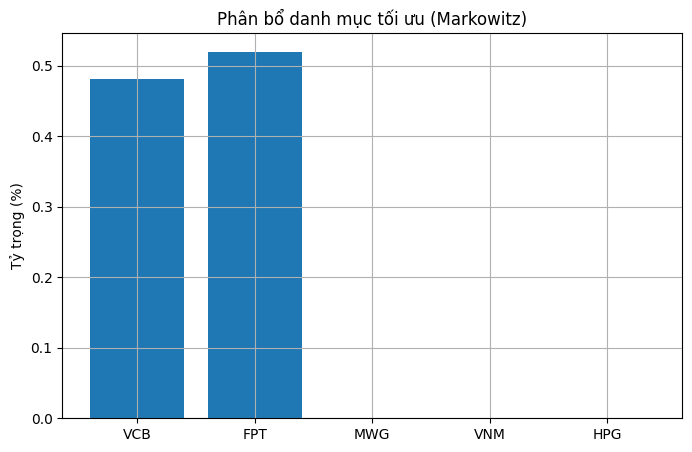

In [7]:
# Vẽ biểu đồ phân bổ danh mục
plt.figure(figsize=(8, 5))
plt.bar(df.columns, optimal_weights)
plt.title("Phân bổ danh mục tối ưu (Markowitz)")
plt.ylabel("Tỷ trọng (%)")
plt.grid(True)
plt.show()
